In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader
import joblib  # Para guardar el scaler
from statsmodels.tsa.stattools import adfuller
from hurst import compute_Hc
from sklearn.preprocessing import RobustScaler
import time
from datetime import timedelta
import os
def load_and_prepare_data(filepath: str) -> pd.DataFrame:
    """Carga y preprocesa los datos del archivo CSV."""
    print(f"📂 Cargando datos desde: {filepath}")
    try:
        df = pd.read_csv(
            f"{filepath}",
            index_col="Fecha",
            parse_dates=True,
            dayfirst=True,
            decimal=",",
            thousands=".",
            converters={
                "Último": lambda x: float(str(x).replace(".", "").replace(",", ".")) if x else np.nan,
                "Apertura": lambda x: float(str(x).replace(".", "").replace(",", ".")) if x else np.nan,
                "Máximo": lambda x: float(str(x).replace(".", "").replace(",", ".")) if x else np.nan,
                "Mínimo": lambda x: float(str(x).replace(".", "").replace(",", ".")) if x else np.nan,
                "% var.": lambda x: float(str(x).replace("%", "").replace(",", ".")) if x else np.nan
            }
        )
        
        df = df.sort_index(ascending=True)
        df = df.dropna(subset=["Último"])
        
        print(f"✅ Datos cargados: {df.shape[0]} filas")
        print(f"📅 Periodo: {df.index.min()} a {df.index.max()}")

        # 🎯 Calcular Hurst
        try:
            ultimo_series = df["Último"].dropna().values
            if len(ultimo_series) > 100:
                H, c, data_hurst = compute_Hc(ultimo_series, kind='price', simplified=True)
                print(f"📈 Exponente de Hurst (H): {H:.4f}")
                if H > 0.55:
                    print("✨ Tendencia persistente (H > 0.5)")
                elif H < 0.45:
                    print("⚡ Anti-persistente (H < 0.5)")
                else:
                    print("🔮 Posible paseo aleatorio (H ≈ 0.5)")
            else:
                print("🙈 No suficientes datos para Hurst.")
        except Exception as e:
            print(f"🚨 Error en Hurst: {e}")

        # 🎯 Test ADF
        try:
            ultimo_series_adf = df["Último"].dropna().values
            if len(ultimo_series_adf) > 0:
                adf_result = adfuller(ultimo_series_adf)
                print(f"\n🧪 Test ADF:")
                print(f"  Estadístico ADF: {adf_result[0]:.4f}")
                print(f"  p-valor: {adf_result[1]:.4f}")
                if adf_result[1] <= 0.05:
                    print("🌟 Serie estacionaria (p <= 0.05)")
                else:
                    print("💤 Serie NO estacionaria (p > 0.05)")
            else:
                print("🚫 Sin datos para ADF.")
        except Exception as e:
            print(f"🚨 Error en ADF: {e}")

        return df
    
    except FileNotFoundError:
        print(f"🚫 Archivo no encontrado: data/{filepath}")
        return None
    except Exception as e:
        print(f"🚨 Error inesperado: {e}")
        return None

def create_sequences(data, seq_length, forecast_horizon):
    """Crea secuencias de entrada (X) y etiquetas de salida (y)."""
    sequences, labels = [], []
    if isinstance(data, pd.DataFrame) or isinstance(data, pd.Series):
        data = data.values
    if data.ndim == 1:
        data = data.reshape(-1, 1)
    print(len(data) - seq_length - forecast_horizon + 1)
    for i in range(len(data) - seq_length - forecast_horizon + 1):
        sequences.append(data[i: i + seq_length])  # X: todas las características (Último + RSI)
        labels.append(data[i + seq_length: i + seq_length + forecast_horizon, 0])  # y: solo "Último" (columna 0)
    return np.array(sequences), np.array(labels)

def add_indicator(data, rsi_window=14, sma_window=20):
    """Calcula múltiples indicadores técnicos y los devuelve en un diccionario"""
    indicators = {}
    
    # Cálculo del RSI
    delta = data["Último"].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(rsi_window).mean()
    avg_loss = loss.rolling(rsi_window).mean()
    rs = avg_gain / avg_loss
    indicators["RSI"] = 100 - (100 / (1 + rs)).fillna(50)
    
    # Cálculo de SMA
    indicators["SMA"] = data["Último"].rolling(window=sma_window).mean().fillna(data["Último"])
    
    # Aquí puedes añadir más indicadores...
    # indicators["NuevoIndicador"] = cálculo...
    
    return indicators

In [4]:
from sklearn.model_selection import train_test_split


df = load_and_prepare_data(os.path.normpath(r'C:\Users\WilhelmB\Documents\LSTM-EUR-USD\data\EUR_USD_2010-2024.csv'))

indicators = add_indicator(df)
for indicator_name, values in indicators.items():
    df[indicator_name] = values 

features = ["Último", "RSI", "SMA"]
df = df[features].dropna()
X,y= create_sequences(df, seq_length=120, forecast_horizon=1)
T = X.shape[1]
D = X.shape[2]
scaler = RobustScaler(quantile_range=(5, 95))
X_shape = X.shape
X_reshaped = X.reshape(-1, D)
X_scaled = scaler.fit_transform(X_reshaped).reshape(X_shape)

# Split again using the scaled X
X_train, X_eval, y_train, y_eval = train_test_split(
    X_scaled, y, test_size=0.2, shuffle=True
)

print(f"Train shapes: X={X_train.shape}, y={y_train.shape}")
print(f"Eval shapes: X={X_eval.shape}, y={y_eval.shape}")
X_train_wo = scaler.inverse_transform(X_train.reshape(-1, D)).reshape(X_train.shape)
X_eval_wo = scaler.inverse_transform(X_eval.reshape(-1, D)).reshape(X_eval.shape)


📂 Cargando datos desde: C:\Users\WilhelmB\Documents\LSTM-EUR-USD\data\EUR_USD_2010-2024.csv
✅ Datos cargados: 3943 filas
📅 Periodo: 2010-01-01 00:00:00 a 2025-02-11 00:00:00
📈 Exponente de Hurst (H): 0.5299
🔮 Posible paseo aleatorio (H ≈ 0.5)

🧪 Test ADF:
  Estadístico ADF: -2.1344
  p-valor: 0.2309
💤 Serie NO estacionaria (p > 0.05)
3823
Train shapes: X=(3058, 120, 3), y=(3058, 1)
Eval shapes: X=(765, 120, 3), y=(765, 1)


In [5]:
# Training code for ContextualLSTMTransformerFlexible (PyTorch version)
# Assumes you have defined: X_train, y_train, device, D, T

import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_torch = torch.tensor(X_train, dtype=torch.float32)
y_train_torch = torch.tensor(y_train, dtype=torch.float32)
X_eval_torch = torch.tensor(X_eval, dtype=torch.float32)
y_eval_torch = torch.tensor(y_eval, dtype=torch.float32)
train_dataset = TensorDataset(X_train_torch, y_train_torch)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = TensorDataset(X_eval_torch, y_eval_torch)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)



# Loss and optimizer

# Training loop with evaluation, early stopping (patience=10), and best model saving
def train_models(model_torch,train_loader,val_loader):
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model_torch.parameters(), lr=1e-3)
    n_epochs = 100
    best_val_loss = float('inf')
    best_model_state = None
    patience = 10
    epochs_no_improve = 0

    model_torch.train()
    train_loss_list = []
    val_loss_list = []
    for epoch in range(n_epochs):
        epoch_loss = 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds = model_torch(xb)
            if preds.shape != yb.shape:
                yb = yb.view_as(preds)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * xb.size(0)
        train_loss = epoch_loss / len(train_loader.dataset)
        train_loss_list.append(train_loss)

        # Evaluation
        model_torch.eval()
        
        val_loss = 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                preds = model_torch(xb)
                if preds.shape != yb.shape:
                    yb = yb.view_as(preds)
                loss = criterion(preds, yb)
                val_loss += loss.item() * xb.size(0)
        val_loss /= len(val_loader.dataset)
        val_loss_list.append(val_loss)
        print(f"Epoch {epoch+1}/{n_epochs} - Train Loss: {train_loss:.6f} - Val Loss: {val_loss:.6f}")

        # Save best model state and handle patience
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = {k: v.cpu().clone() for k, v in model_torch.state_dict().items()}
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch+1} due to no improvement in val_loss for {patience} epochs.")
                break

        model_torch.train()
    return best_model_state, train_loss_list, val_loss_list

# To restore best model later:
# model_torch.load_state_dict(best_model_state)


# TLS_LSTMModel

In [6]:
class TLS_LSTMModel(nn.Module):
    def __init__(self, input_size=2, hidden_size=512, output_size=1, dropout_prob=0.2):
        super(TLS_LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.dropout1 = nn.Dropout(dropout_prob)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.dropout2 = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm1_out, _ = self.lstm1(x)
        lstm1_out = self.dropout1(lstm1_out)
        lstm2_out, _ = self.lstm2(lstm1_out)
        lstm2_out = self.dropout2(lstm2_out)
        last_time_step_out = lstm2_out[:, -1, :]
        out = self.fc(last_time_step_out)
        return out

In [8]:
model_TLS_LSTMModel = TLS_LSTMModel(input_size=D, hidden_size=512, output_size=1, dropout_prob=0.10976329984400868).to(device)
best_model_TLS_LSTMModel, loss_train_TLS_LSTMModel, loss_val_TLS_LSTMModel = train_models(model_TLS_LSTMModel,train_loader,val_loader)

model_TLS_LSTMModel.load_state_dict(best_model_TLS_LSTMModel)

Epoch 1/100 - Train Loss: 0.405170 - Val Loss: 0.000438
Epoch 2/100 - Train Loss: 0.001195 - Val Loss: 0.000146
Epoch 3/100 - Train Loss: 0.001235 - Val Loss: 0.000116
Epoch 4/100 - Train Loss: 0.001118 - Val Loss: 0.000139
Epoch 5/100 - Train Loss: 0.001102 - Val Loss: 0.000109
Epoch 6/100 - Train Loss: 0.001035 - Val Loss: 0.000135
Epoch 7/100 - Train Loss: 0.001039 - Val Loss: 0.000285
Epoch 8/100 - Train Loss: 0.000943 - Val Loss: 0.000235
Epoch 9/100 - Train Loss: 0.000920 - Val Loss: 0.000105
Epoch 10/100 - Train Loss: 0.000941 - Val Loss: 0.000100
Epoch 11/100 - Train Loss: 0.000885 - Val Loss: 0.000137
Epoch 12/100 - Train Loss: 0.000865 - Val Loss: 0.000170
Epoch 13/100 - Train Loss: 0.000746 - Val Loss: 0.000093
Epoch 14/100 - Train Loss: 0.000842 - Val Loss: 0.000125
Epoch 15/100 - Train Loss: 0.000762 - Val Loss: 0.000132
Epoch 16/100 - Train Loss: 0.000728 - Val Loss: 0.000311
Epoch 17/100 - Train Loss: 0.000809 - Val Loss: 0.000133
Epoch 18/100 - Train Loss: 0.000762 - Va

<All keys matched successfully>

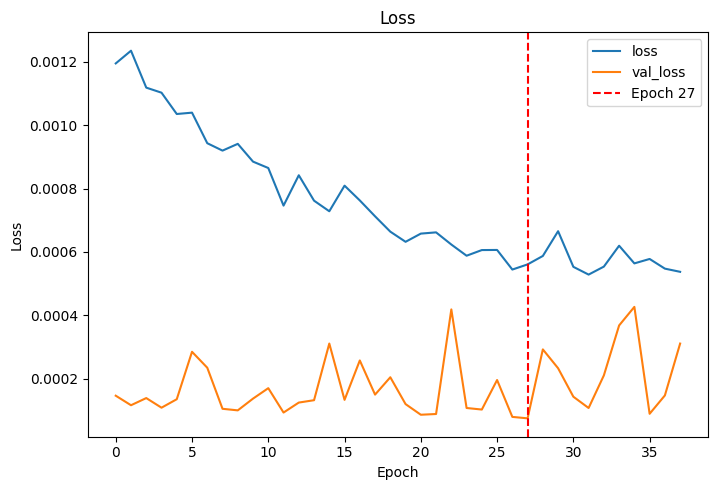

In [9]:
import matplotlib.pyplot as plt

# Plot loss and val_loss
plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
plt.plot(loss_train_TLS_LSTMModel[1:], label='loss')
plt.plot(loss_val_TLS_LSTMModel[1:], label='val_loss')
plt.axvline(39-2-10, color='red', linestyle='--', label=f'Epoch {39-2-10}')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# HybridLSTMAttentionModel

In [10]:
class HybridLSTMAttentionModel(nn.Module):
    def __init__(self, input_size=3, hidden_size=512, output_size=1, dropout_prob=0.1):
        super(HybridLSTMAttentionModel, self).__init__()
        # Capas LSTM
        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.dropout1 = nn.Dropout(dropout_prob)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, batch_first=True)

        # Mecanismo de Atención
        self.attention = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.Tanh(),
            nn.Linear(hidden_size // 2, 1),
            nn.Softmax(dim=1),
        )

        # Capas Fully Connected
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(hidden_size // 2, output_size),
        )

        # Inicialización de pesos
        self._init_weights()

    def _init_weights(self):
        for name, param in self.named_parameters():
            if "weight" in name and param.dim() > 1:  # Solo para matrices
                nn.init.xavier_uniform_(param)
            elif "bias" in name:  # Para biases
                nn.init.constant_(param, 0.0)

    def forward(self, x):
        # Capas LSTM
        lstm1_out, _ = self.lstm1(x)
        lstm1_out = self.dropout1(lstm1_out)
        lstm2_out, _ = self.lstm2(lstm1_out)

        # Atención
        attention_weights = self.attention(lstm2_out)
        context_vector = torch.sum(attention_weights * lstm2_out, dim=1)

        # Salida final
        out = self.fc(context_vector)
        return out.squeeze(-1)  # Asegura forma (batch_size,)


In [11]:
model_HybridLSTMAttentionModel = HybridLSTMAttentionModel(input_size=D, hidden_size=512, output_size=1, dropout_prob=0.10976329984400868).to(device)
best_model_HybridLSTMAttentionModel, loss_train_HybridLSTMAttentionModel, loss_val_HybridLSTMAttentionModel = train_models(model_HybridLSTMAttentionModel,train_loader,val_loader)

model_HybridLSTMAttentionModel.load_state_dict(best_model_HybridLSTMAttentionModel)

Epoch 1/100 - Train Loss: 0.072762 - Val Loss: 0.000882
Epoch 2/100 - Train Loss: 0.003003 - Val Loss: 0.000868
Epoch 3/100 - Train Loss: 0.002953 - Val Loss: 0.000623
Epoch 4/100 - Train Loss: 0.002476 - Val Loss: 0.000615
Epoch 5/100 - Train Loss: 0.002639 - Val Loss: 0.000561
Epoch 6/100 - Train Loss: 0.002338 - Val Loss: 0.001563
Epoch 7/100 - Train Loss: 0.002649 - Val Loss: 0.000983
Epoch 8/100 - Train Loss: 0.002659 - Val Loss: 0.001708
Epoch 9/100 - Train Loss: 0.002598 - Val Loss: 0.001367
Epoch 10/100 - Train Loss: 0.002402 - Val Loss: 0.001961
Epoch 11/100 - Train Loss: 0.002211 - Val Loss: 0.000533
Epoch 12/100 - Train Loss: 0.002420 - Val Loss: 0.000907
Epoch 13/100 - Train Loss: 0.002195 - Val Loss: 0.000522
Epoch 14/100 - Train Loss: 0.002347 - Val Loss: 0.000674
Epoch 15/100 - Train Loss: 0.002254 - Val Loss: 0.000983
Epoch 16/100 - Train Loss: 0.002084 - Val Loss: 0.001379
Epoch 17/100 - Train Loss: 0.002198 - Val Loss: 0.001868
Epoch 18/100 - Train Loss: 0.002661 - Va

<All keys matched successfully>

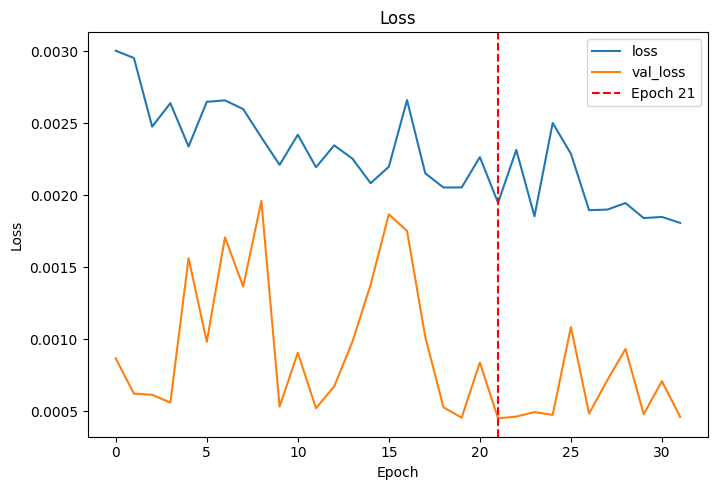

In [12]:
import matplotlib.pyplot as plt

# Plot loss and val_loss
plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
plt.plot(loss_train_HybridLSTMAttentionModel[1:], label='loss')
plt.plot(loss_val_HybridLSTMAttentionModel[1:], label='val_loss')
plt.axvline(33-2-10, color='red', linestyle='--', label=f'Epoch {33-2-10}')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# BidirectionalDeepLSTMModel

In [13]:
class BidirectionalDeepLSTMModel(nn.Module):
    def __init__(self, input_size=2, hidden_size=512, output_size=1, dropout_prob=0.2):
        super(BidirectionalDeepLSTMModel, self).__init__()
        self.lstm = nn.LSTM(
            input_size, hidden_size, batch_first=True, bidirectional=True, num_layers=2
        )
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),  # *2 por bidirectional
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(hidden_size, output_size),
        )

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_out = self.dropout(lstm_out)
        out = self.fc(lstm_out[:, -1, :])
        return out

In [14]:
model_BidirectionalDeepLSTMModel = BidirectionalDeepLSTMModel(input_size=D, hidden_size=512, output_size=1, dropout_prob=0.10976329984400868).to(device)
best_model_BidirectionalDeepLSTMModel, loss_train_BidirectionalDeepLSTMModel, loss_val_BidirectionalDeepLSTMModel = train_models(model_BidirectionalDeepLSTMModel,train_loader,val_loader)

model_BidirectionalDeepLSTMModel.load_state_dict(best_model_BidirectionalDeepLSTMModel)

Epoch 1/100 - Train Loss: 0.167528 - Val Loss: 0.000087
Epoch 2/100 - Train Loss: 0.002021 - Val Loss: 0.000269
Epoch 3/100 - Train Loss: 0.002106 - Val Loss: 0.000069
Epoch 4/100 - Train Loss: 0.001823 - Val Loss: 0.000848
Epoch 5/100 - Train Loss: 0.001767 - Val Loss: 0.000060
Epoch 6/100 - Train Loss: 0.001667 - Val Loss: 0.000076
Epoch 7/100 - Train Loss: 0.001589 - Val Loss: 0.000095
Epoch 8/100 - Train Loss: 0.001546 - Val Loss: 0.000111
Epoch 9/100 - Train Loss: 0.001515 - Val Loss: 0.000064
Epoch 10/100 - Train Loss: 0.001490 - Val Loss: 0.000105
Epoch 11/100 - Train Loss: 0.001455 - Val Loss: 0.000077
Epoch 12/100 - Train Loss: 0.001527 - Val Loss: 0.000200
Epoch 13/100 - Train Loss: 0.001516 - Val Loss: 0.000271
Epoch 14/100 - Train Loss: 0.001302 - Val Loss: 0.000050
Epoch 15/100 - Train Loss: 0.001373 - Val Loss: 0.000064
Epoch 16/100 - Train Loss: 0.001318 - Val Loss: 0.000251
Epoch 17/100 - Train Loss: 0.001438 - Val Loss: 0.000121
Epoch 18/100 - Train Loss: 0.001288 - Va

<All keys matched successfully>

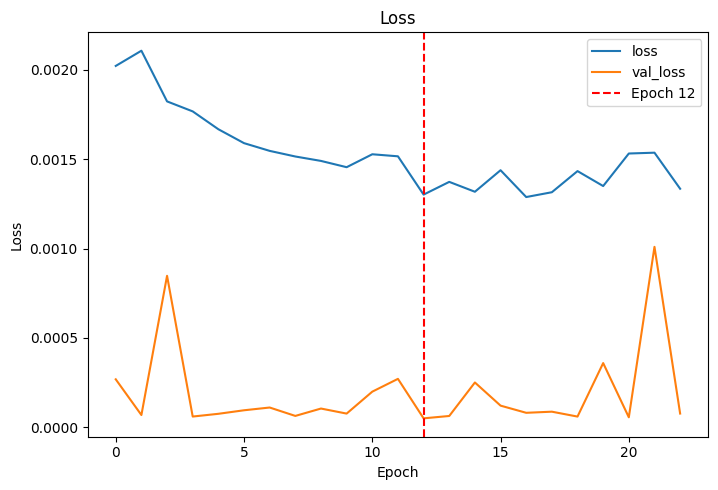

In [15]:
import matplotlib.pyplot as plt

# Plot loss and val_loss
plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
plt.plot(loss_train_BidirectionalDeepLSTMModel[1:], label='loss')
plt.plot(loss_val_BidirectionalDeepLSTMModel[1:], label='val_loss')
plt.axvline(24-2-10, color='red', linestyle='--', label=f'Epoch {24-2-10}')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# GRU_Model

In [16]:
class GRU_Model(nn.Module):
    def __init__(
        self,
        input_size=2,
        hidden_size=512,
        output_size=1,
        dropout_prob=0.2,
        num_layers=2,
    ):
        super(GRU_Model, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Capas GRU
        self.gru1 = nn.GRU(
            input_size, hidden_size, num_layers=num_layers, batch_first=True
        )
        self.dropout1 = nn.Dropout(dropout_prob)
        self.gru2 = nn.GRU(
            hidden_size, hidden_size, num_layers=num_layers, batch_first=True
        )
        self.dropout2 = nn.Dropout(dropout_prob)

        # Capa fully connected
        self.fc = nn.Linear(hidden_size, output_size)

        # Inicialización de pesos
        self.init_weights()

    def init_weights(self):
        for name, param in self.named_parameters():
            if "weight" in name:
                nn.init.xavier_uniform_(param)
            elif "bias" in name:
                nn.init.zeros_(param)

    def forward(self, x):
        # Primera capa GRU
        gru1_out, _ = self.gru1(x)
        gru1_out = self.dropout1(gru1_out)

        # Segunda capa GRU
        gru2_out, _ = self.gru2(gru1_out)
        gru2_out = self.dropout2(gru2_out)

        # Tomar la última secuencia y pasar por FC
        out = self.fc(gru2_out[:, -1, :])
        return out


In [17]:
model_GRU_Model = GRU_Model(input_size=D, hidden_size=512, output_size=1, dropout_prob=0.10976329984400868).to(device)
best_model_GRU_Model, loss_train_GRU_Model, loss_val_GRU_Model = train_models(model_GRU_Model,train_loader,val_loader)

model_GRU_Model.load_state_dict(best_model_GRU_Model)

Epoch 1/100 - Train Loss: 0.049528 - Val Loss: 0.000265
Epoch 2/100 - Train Loss: 0.000922 - Val Loss: 0.000359
Epoch 3/100 - Train Loss: 0.000993 - Val Loss: 0.000431
Epoch 4/100 - Train Loss: 0.001649 - Val Loss: 0.000538
Epoch 5/100 - Train Loss: 0.000841 - Val Loss: 0.000373
Epoch 6/100 - Train Loss: 0.000879 - Val Loss: 0.000091
Epoch 7/100 - Train Loss: 0.000800 - Val Loss: 0.000208
Epoch 8/100 - Train Loss: 0.000971 - Val Loss: 0.000794
Epoch 9/100 - Train Loss: 0.000907 - Val Loss: 0.000079
Epoch 10/100 - Train Loss: 0.000768 - Val Loss: 0.000226
Epoch 11/100 - Train Loss: 0.000868 - Val Loss: 0.000549
Epoch 12/100 - Train Loss: 0.000707 - Val Loss: 0.000173
Epoch 13/100 - Train Loss: 0.000923 - Val Loss: 0.000076
Epoch 14/100 - Train Loss: 0.000826 - Val Loss: 0.000239
Epoch 15/100 - Train Loss: 0.000645 - Val Loss: 0.000233
Epoch 16/100 - Train Loss: 0.000777 - Val Loss: 0.000141
Epoch 17/100 - Train Loss: 0.000925 - Val Loss: 0.000077
Epoch 18/100 - Train Loss: 0.000658 - Va

<All keys matched successfully>

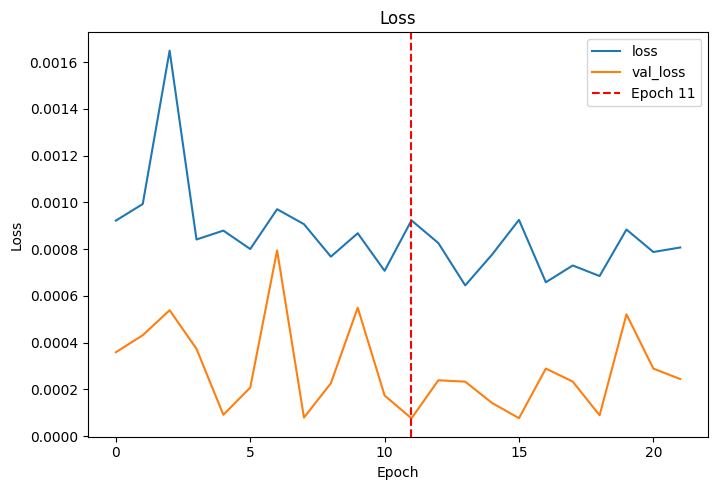

In [18]:
import matplotlib.pyplot as plt

# Plot loss and val_loss
plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
plt.plot(loss_train_GRU_Model[1:], label='loss')
plt.plot(loss_val_GRU_Model[1:], label='val_loss')
plt.axvline(23-2-10, color='red', linestyle='--', label=f'Epoch {23-2-10}')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# ContextualLSTMTransformerFlexible

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LSTMWithSelfAttention(nn.Module):
    def __init__(self, input_dim, lstm_units, num_heads, dropout_rate=0.1):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, lstm_units, batch_first=True, bidirectional=True)
        self.self_attn = nn.MultiheadAttention(lstm_units * 2, num_heads, dropout=dropout_rate, batch_first=True)
        self.norm = nn.LayerNorm(lstm_units * 2)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        # x: (batch, seq, features)
        x, _ = self.lstm(x)
        attn_out, _ = self.self_attn(x, x, x)
        x = self.norm(x + self.dropout(attn_out))
        return x

class CrossAttentionBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout_rate=0.1):
        super().__init__()
        self.cross_attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout_rate, batch_first=True)
        self.norm = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, query, context):
        # query: (batch, 1, embed_dim), context: (batch, N, embed_dim)
        attn_out, _ = self.cross_attn(query, context, context)
        return self.norm(query + self.dropout(attn_out))

class ReshapeToWindows(nn.Module):
    def __init__(self, seq_len, window_size, feature_dim):
        super().__init__()
        self.seq_len = seq_len
        self.window_size = window_size
        self.feature_dim = feature_dim

    def forward(self, x):
        # x: (batch, seq_len, feature_dim)
        num_windows = self.seq_len // self.window_size
        x = x[:, :num_windows * self.window_size, :]
        x = x.view(x.size(0), num_windows, self.window_size, self.feature_dim)
        return x

class ContextualLSTMTransformerFlexible(nn.Module):
    def __init__(
        self,
        seq_len,
        feature_dim,
        output_size=5,  # Para regresión
        window_size=32,
        max_neighbors=2,
        lstm_units=64,
        num_heads=4,
        embed_dim=128,
        dropout_rate=0.1
    ):
        super().__init__()
        assert window_size % 2 == 0, "window_size debe ser par"
        self.seq_len = seq_len
        self.feature_dim = feature_dim
        self.output_size = output_size  # Para regresión
        self.window_size = window_size
        self.max_neighbors = max_neighbors
        self.lstm_units = lstm_units
        self.num_heads = num_heads
        self.embed_dim = embed_dim
        self.dropout_rate = dropout_rate

        self.reshape = ReshapeToWindows(seq_len, window_size, feature_dim)
        self.lstm_attn_block = LSTMWithSelfAttention(feature_dim, lstm_units, num_heads, dropout_rate)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.cross_attn_blocks = nn.ModuleList([
            CrossAttentionBlock(embed_dim, num_heads, dropout_rate)
            for _ in range(seq_len // window_size)
        ])
        self.final_dense1 = nn.Linear(embed_dim * (seq_len // window_size), 64)
        self.final_dense2 = nn.Linear(64, self.output_size)

        # Project LSTM output to embed_dim for attention
        self.project = nn.Linear(lstm_units * 2, embed_dim)

    def forward(self, x):
        # x: (batch, seq_len, feature_dim)
        batch_size = x.size(0)
        num_windows = self.seq_len // self.window_size

        x = self.reshape(x)  # (batch, num_windows, window_size, feature_dim)
        x = x.reshape(-1, self.window_size, self.feature_dim)  # (batch*num_windows, window_size, feature_dim)
        x = self.lstm_attn_block(x)  # (batch*num_windows, window_size, lstm_units*2)
        x = self.project(x)  # (batch*num_windows, window_size, embed_dim)
        x = x.mean(dim=1)  # (batch*num_windows, embed_dim)
        x = x.view(batch_size, num_windows, self.embed_dim)  # (batch, num_windows, embed_dim)

        window_outputs = []
        for center_idx in range(num_windows):
            left = max(0, center_idx - self.max_neighbors)
            right = min(num_windows, center_idx + self.max_neighbors + 1)
            context_indices = [i for i in range(left, right) if i != center_idx]

            # context: (batch, len(context_indices), embed_dim)
            context = x[:, context_indices, :]
            # center: (batch, 1, embed_dim)
            center = x[:, center_idx:center_idx+1, :]

            attended = self.cross_attn_blocks[center_idx](center, context)
            window_outputs.append(attended)

        output_sequence = torch.cat(window_outputs, dim=1)  # (batch, num_windows, embed_dim)
        out = output_sequence.view(batch_size, -1)  # flatten
        out = F.relu(self.final_dense1(out))
        out = self.final_dense2(out)
        return out.squeeze(-1)

# Example instantiation:
# model = ContextualLSTMTransformerFlexible(
#     seq_len=T,
#     feature_dim=D,
#     window_size=6,
#     max_neighbors=1,
#     lstm_units=64,
#     num_heads=2,
#     embed_dim=128,
#     dropout_rate=0.1
# )


In [20]:
# Instantiate model
model_ContextualLSTMTransformerFlexible = ContextualLSTMTransformerFlexible(
    seq_len=T,
    feature_dim=D,
    output_size=1,
    window_size=6,
    max_neighbors=1,
    lstm_units=64,
    num_heads=4,
    embed_dim=128,
    dropout_rate=0.1
).to(device)


best_model_ContextualLSTMTransformerFlexible, loss_train_ContextualLSTMTransformerFlexible, loss_val_ContextualLSTMTransformerFlexible = train_models(model_ContextualLSTMTransformerFlexible,train_loader,val_loader)

model_ContextualLSTMTransformerFlexible.load_state_dict(best_model_ContextualLSTMTransformerFlexible)


Epoch 1/100 - Train Loss: 0.280904 - Val Loss: 0.001447
Epoch 2/100 - Train Loss: 0.001058 - Val Loss: 0.000892
Epoch 3/100 - Train Loss: 0.000695 - Val Loss: 0.000832
Epoch 4/100 - Train Loss: 0.000625 - Val Loss: 0.000575
Epoch 5/100 - Train Loss: 0.000512 - Val Loss: 0.000870
Epoch 6/100 - Train Loss: 0.000452 - Val Loss: 0.001610
Epoch 7/100 - Train Loss: 0.000386 - Val Loss: 0.001364
Epoch 8/100 - Train Loss: 0.000401 - Val Loss: 0.000320
Epoch 9/100 - Train Loss: 0.000380 - Val Loss: 0.000575
Epoch 10/100 - Train Loss: 0.000354 - Val Loss: 0.001399
Epoch 11/100 - Train Loss: 0.000318 - Val Loss: 0.000585
Epoch 12/100 - Train Loss: 0.000319 - Val Loss: 0.000286
Epoch 13/100 - Train Loss: 0.000306 - Val Loss: 0.000501
Epoch 14/100 - Train Loss: 0.000303 - Val Loss: 0.000719
Epoch 15/100 - Train Loss: 0.000282 - Val Loss: 0.000740
Epoch 16/100 - Train Loss: 0.000396 - Val Loss: 0.000371
Epoch 17/100 - Train Loss: 0.000350 - Val Loss: 0.000163
Epoch 18/100 - Train Loss: 0.000325 - Va

<All keys matched successfully>

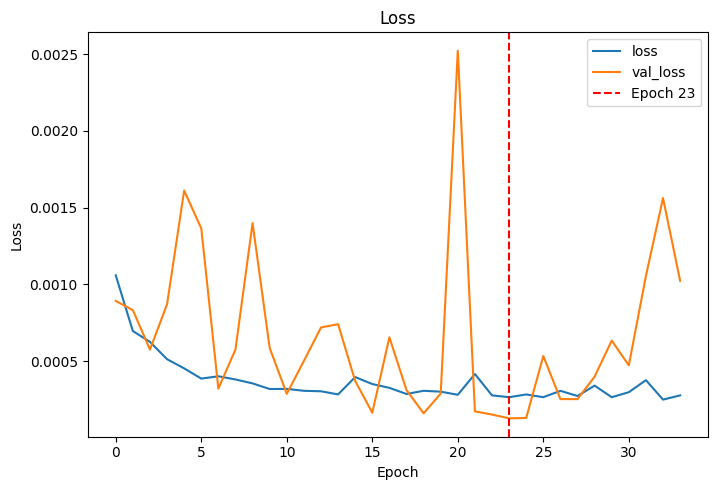

In [21]:
import matplotlib.pyplot as plt

# Plot loss and val_loss
plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
plt.plot(loss_train_ContextualLSTMTransformerFlexible[1:], label='loss')
plt.plot(loss_val_ContextualLSTMTransformerFlexible[1:], label='val_loss')
plt.axvline(35-2-10, color='red', linestyle='--', label=f'Epoch {35-2-10}')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

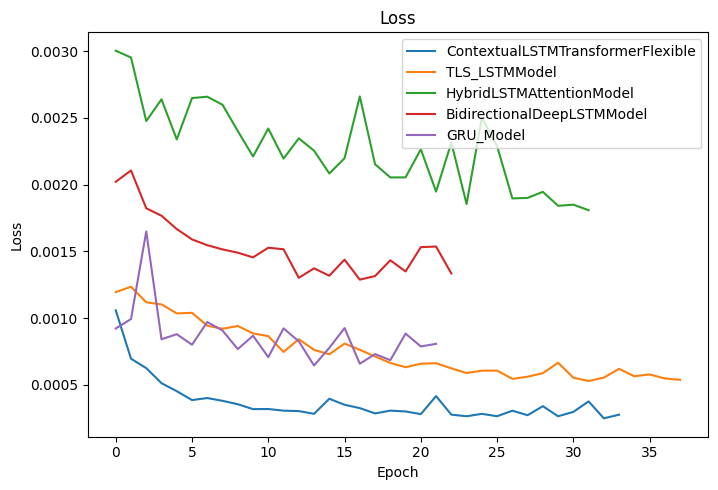

In [22]:
import matplotlib.pyplot as plt

# Plot loss and val_loss
plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
plt.plot(loss_train_ContextualLSTMTransformerFlexible[1:], label='ContextualLSTMTransformerFlexible')
plt.plot(loss_train_TLS_LSTMModel[1:], label='TLS_LSTMModel')
plt.plot(loss_train_HybridLSTMAttentionModel[1:], label='HybridLSTMAttentionModel')
plt.plot(loss_train_BidirectionalDeepLSTMModel[1:], label='BidirectionalDeepLSTMModel')
plt.plot(loss_train_GRU_Model[1:], label='GRU_Model')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

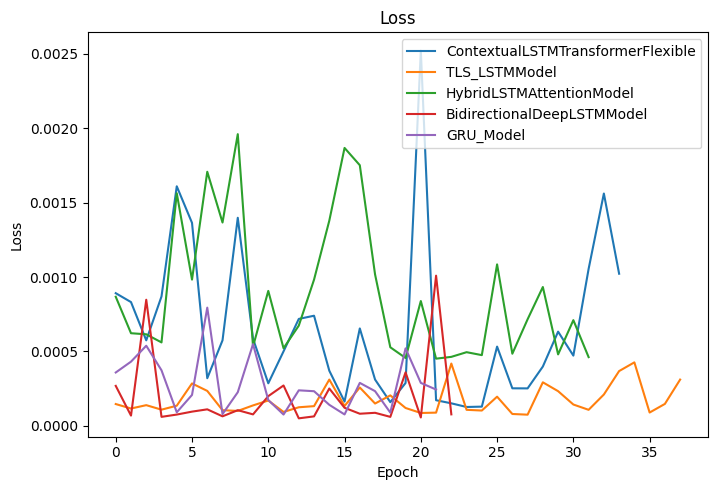

In [23]:
import matplotlib.pyplot as plt

# Plot loss and val_loss
plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
plt.plot(loss_val_ContextualLSTMTransformerFlexible[1:], label='ContextualLSTMTransformerFlexible')
plt.plot(loss_val_TLS_LSTMModel[1:], label='TLS_LSTMModel')
plt.plot(loss_val_HybridLSTMAttentionModel[1:], label='HybridLSTMAttentionModel')
plt.plot(loss_val_BidirectionalDeepLSTMModel[1:], label='BidirectionalDeepLSTMModel')
plt.plot(loss_val_GRU_Model[1:], label='GRU_Model')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [29]:
import torch
import gc

gc.collect()                          # Recolección de basura de Python
torch.cuda.empty_cache()             # Libera la memoria que no se está usando pero sigue asignada
torch.cuda.ipc_collect()             # Libera la memoria compartida entre procesos



                               Model       MAE       MSE      RMSE       R^2  \
0                      TLS_LSTMModel  0.006510  0.000073  0.008543  0.994241   
1           HybridLSTMAttentionModel  0.016368  0.000463  0.021514  0.963476   
2         BidirectionalDeepLSTMModel       NaN       NaN       NaN       NaN   
3                          GRU_Model  0.006679  0.000074  0.008599  0.994165   
4  ContextualLSTMTransformerFlexible  0.008659  0.000123  0.011112  0.990257   

   MAPE (%)  
0  0.547221  
1  1.380579  
2       NaN  
3  0.559682  
4  0.728151  


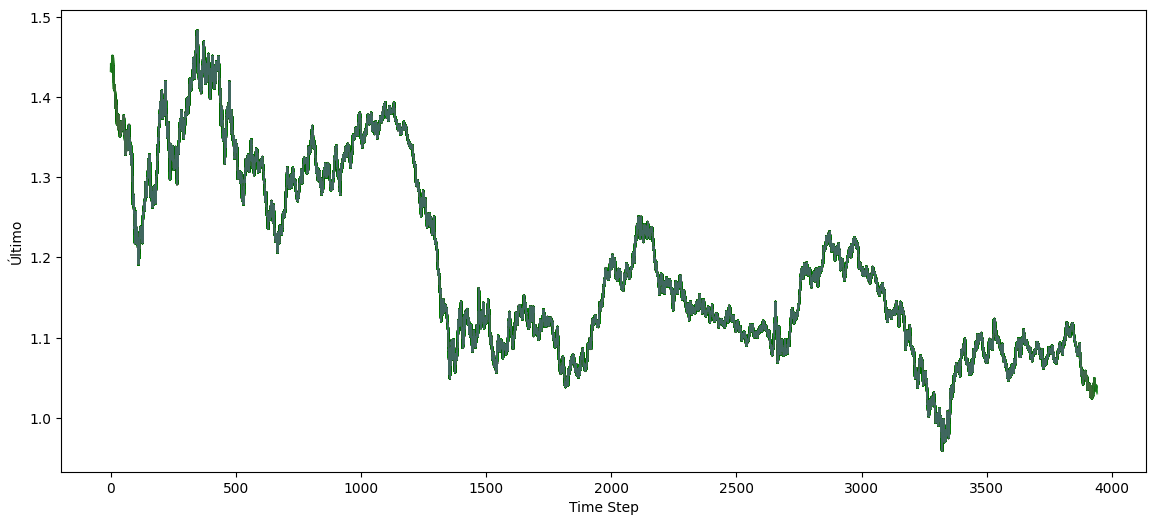

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import torch
import matplotlib.pyplot as plt
model_TLS_LSTMModel.eval()
model_HybridLSTMAttentionModel.eval()
model_BidirectionalDeepLSTMModel.eval()
model_GRU_Model.eval()
model_ContextualLSTMTransformerFlexible.eval()
# Predict for all X samples
X_2 = torch.tensor(X_scaled, dtype=torch.float32).to(device)
y_pred_all_tls = model_TLS_LSTMModel(X_2).cpu().detach().numpy() 
gc.collect()                          # Recolección de basura de Python
torch.cuda.empty_cache()             # Libera la memoria que no se está usando pero sigue asignada
torch.cuda.ipc_collect()             # Libera la memoria compartida entre procesos
y_pred_all_hybrid = model_HybridLSTMAttentionModel(X_2).cpu().detach().numpy() 
gc.collect()                          # Recolección de basura de Python
torch.cuda.empty_cache()             # Libera la memoria que no se está usando pero sigue asignada
torch.cuda.ipc_collect()             # Libera la memoria compartida entre procesos
#y_pred_all_bi = model_BidirectionalDeepLSTMModel(X_2).cpu().detach().numpy() 
y_pred_all_gru = model_GRU_Model(X_2).cpu().detach().numpy() 
gc.collect()                          # Recolección de basura de Python
torch.cuda.empty_cache()             # Libera la memoria que no se está usando pero sigue asignada
torch.cuda.ipc_collect()             # Libera la memoria compartida entre procesos
y_pred_all_contextual = model_ContextualLSTMTransformerFlexible(X_2).cpu().detach().numpy() 
gc.collect()                          # Recolección de basura de Python
torch.cuda.empty_cache()             # Libera la memoria que no se está usando pero sigue asignada
torch.cuda.ipc_collect()             # Libera la memoria compartida entre procesos
# Flatten for metrics (if needed)
y_true_flat = y.reshape(-1)
y_pred_flat_tls = y_pred_all_tls.flatten()
y_pred_flat_hybrid = y_pred_all_hybrid.flatten()
#y_pred_flat_bi = y_pred_all_bi.flatten()
y_pred_flat_gru = y_pred_all_gru.flatten()
y_pred_flat_contextual = y_pred_all_contextual.flatten()


# Calculate metrics
# For TLS_LSTMModel
mae_tls = mean_absolute_error(y_true_flat, y_pred_flat_tls)
mse_tls = mean_squared_error(y_true_flat, y_pred_flat_tls)
rmse_tls = np.sqrt(mse_tls)
r2_tls = r2_score(y_true_flat, y_pred_flat_tls)
mape_tls = np.mean(np.abs((y_true_flat - y_pred_flat_tls) / y_true_flat)) * 100
# For HybridLSTMAttentionModel
mae_hybrid = mean_absolute_error(y_true_flat, y_pred_flat_hybrid)
mse_hybrid = mean_squared_error(y_true_flat, y_pred_flat_hybrid)
rmse_hybrid = np.sqrt(mse_hybrid)
r2_hybrid = r2_score(y_true_flat, y_pred_flat_hybrid)
mape_hybrid = np.mean(np.abs((y_true_flat - y_pred_flat_hybrid) / y_true_flat)) * 100
# For BidirectionalDeepLSTMModel
#mae_bi = mean_absolute_error(y_true_flat, y_pred_flat_bi)
#mse_bi = mean_squared_error(y_true_flat, y_pred_flat_bi)
#rmse_bi = np.sqrt(mse_bi)
#r2_bi = r2_score(y_true_flat, y_pred_flat_bi)
#mape_bi = np.mean(np.abs((y_true_flat - y_pred_flat_bi) / y_true_flat)) * 100
# For GRU_Model
mae_gru = mean_absolute_error(y_true_flat, y_pred_flat_gru)
mse_gru = mean_squared_error(y_true_flat, y_pred_flat_gru)
rmse_gru = np.sqrt(mse_gru)
r2_gru = r2_score(y_true_flat, y_pred_flat_gru)
mape_gru = np.mean(np.abs((y_true_flat - y_pred_flat_gru) / y_true_flat)) * 100
# For ContextualLSTMTransformerFlexible
mae_contextual = mean_absolute_error(y_true_flat, y_pred_flat_contextual)
mse_contextual = mean_squared_error(y_true_flat, y_pred_flat_contextual)
rmse_contextual = np.sqrt(mse_contextual)
r2_contextual = r2_score(y_true_flat, y_pred_flat_contextual)
mape_contextual = np.mean(np.abs((y_true_flat - y_pred_flat_contextual) / y_true_flat)) * 100
# generate a dataframe to store the results
results = pd.DataFrame({
    'Model': ['TLS_LSTMModel', 'HybridLSTMAttentionModel', 'BidirectionalDeepLSTMModel', 'GRU_Model', 'ContextualLSTMTransformerFlexible'],
    'MAE': [mae_tls, mae_hybrid, None, mae_gru, mae_contextual],
    'MSE': [mse_tls, mse_hybrid, None, mse_gru, mse_contextual],
    'RMSE': [rmse_tls, rmse_hybrid, None, rmse_gru, rmse_contextual],
    'R^2': [r2_tls, r2_hybrid, None, r2_gru, r2_contextual],
    'MAPE (%)': [mape_tls, mape_hybrid, None, mape_gru, mape_contextual]
})

print(results)

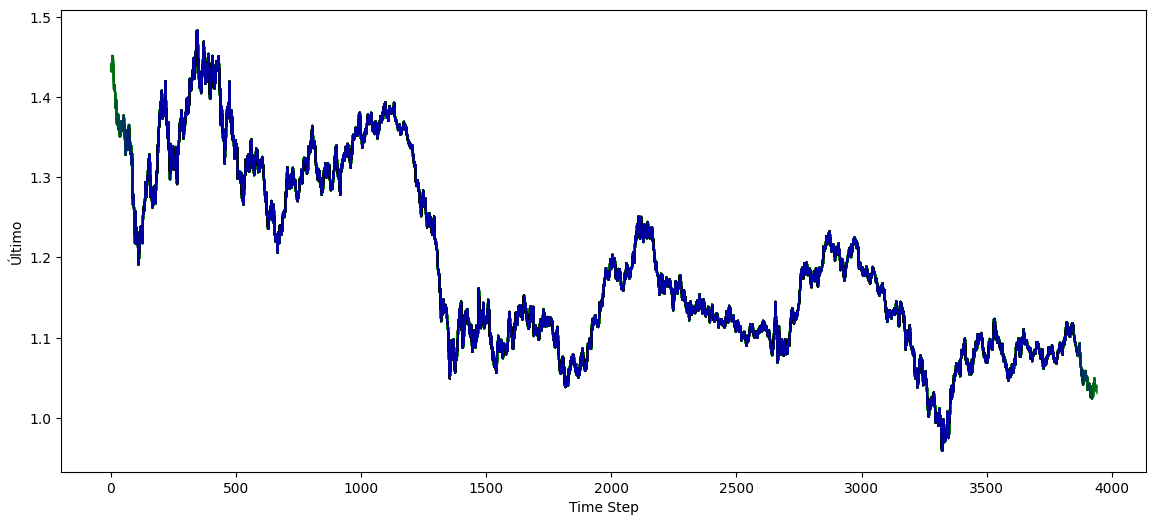

In [ ]:

plt.figure(figsize=(14, 6))
ultimo_idx  = 0
# Plot all true future values
for i in range(len(y)):
    plt.plot(range(i, i + T), X[i, :, ultimo_idx], y[i].flatten(), color='green', alpha=0.6)

# Plot all predicted future values
for i in range(len(y_pred_all_tls)):
    plt.plot(range(i, i + T), X[i, :, ultimo_idx], y_pred_all_tls[i].flatten(),alpha=0.01, color='blue')

for i in range(len(y_pred_all_hybrid)):
    plt.plot(range(i, i + T), X[i, :, ultimo_idx], y_pred_all_hybrid[i].flatten(), alpha=0.01, color='orange')

#for i in range(len(y_pred_all_bi)):
    #plt.plot(range(i, i + T), X[i, :, ultimo_idx], y_pred_all_bi[i].flatten(), alpha=0.01)

for i in range(len(y_pred_all_gru)):
    plt.plot(range(i, i + T), X[i, :, ultimo_idx], y_pred_all_gru[i].flatten(), alpha=0.01, color='red')

for i in range(len(y_pred_all_contextual)):
    plt.plot(range(i, i + T), X[i, :, ultimo_idx], y_pred_all_contextual[i].flatten(), alpha=0.01, color='purple')

plt.xlabel("Time Step")
plt.ylabel("Último")
plt.title("")
plt.show()

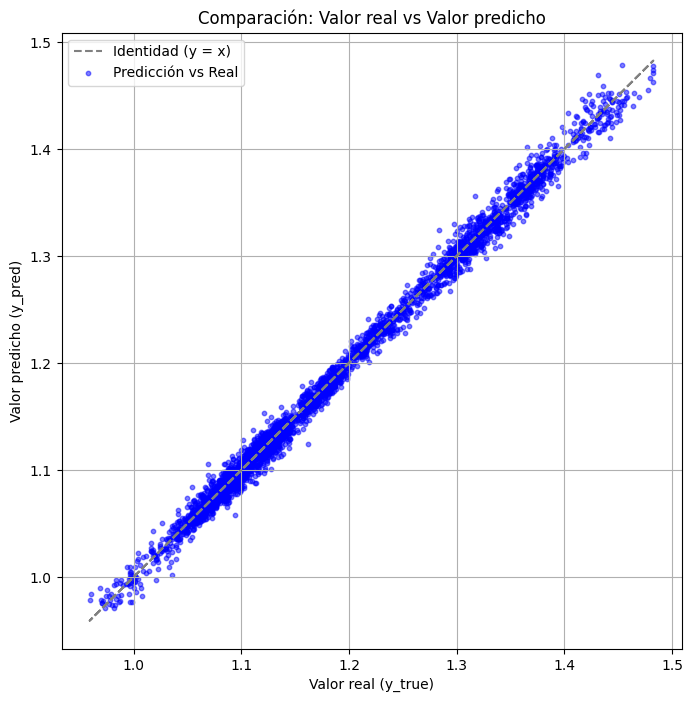

In [34]:
import numpy as np

import matplotlib.pyplot as plt

# Gráfica de la identidad
plt.figure(figsize=(8, 8))
plt.plot(y_true_flat, y_true_flat, label="Identidad (y = x)", color='gray', linestyle='--')

# Gráfica de y_true vs y_pred
plt.scatter(y_true_flat, y_pred_flat_tls, alpha=0.5, label="Predicción vs Real", color='blue', s=10)

plt.xlabel("Valor real (y_true)")
plt.ylabel("Valor predicho (y_pred)")
plt.title("Comparación: Valor real vs Valor predicho")
plt.legend()
plt.grid(True)
plt.show()

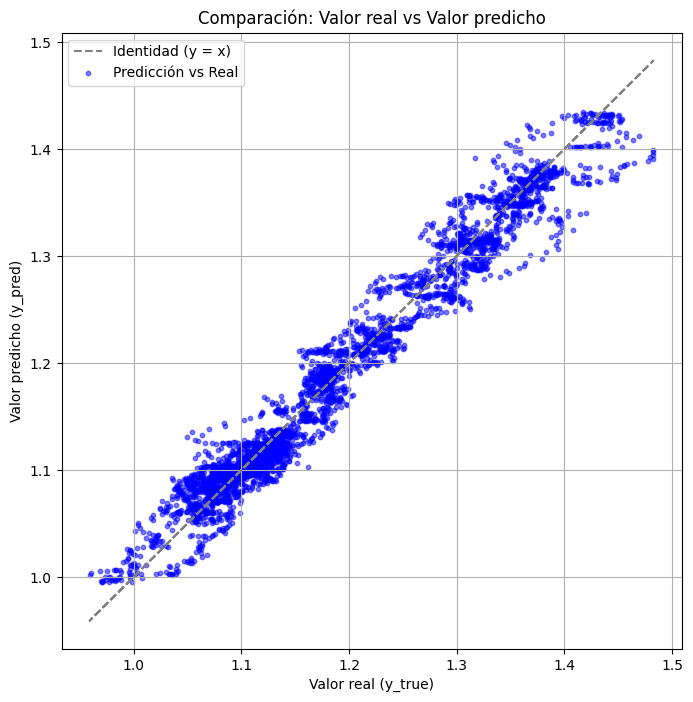

In [35]:
import numpy as np

import matplotlib.pyplot as plt

# Gráfica de la identidad
plt.figure(figsize=(8, 8))
plt.plot(y_true_flat, y_true_flat, label="Identidad (y = x)", color='gray', linestyle='--')

# Gráfica de y_true vs y_pred
plt.scatter(y_true_flat, y_pred_flat_hybrid, alpha=0.5, label="Predicción vs Real", color='blue', s=10)

plt.xlabel("Valor real (y_true)")
plt.ylabel("Valor predicho (y_pred)")
plt.title("Comparación: Valor real vs Valor predicho")
plt.legend()
plt.grid(True)
plt.show()

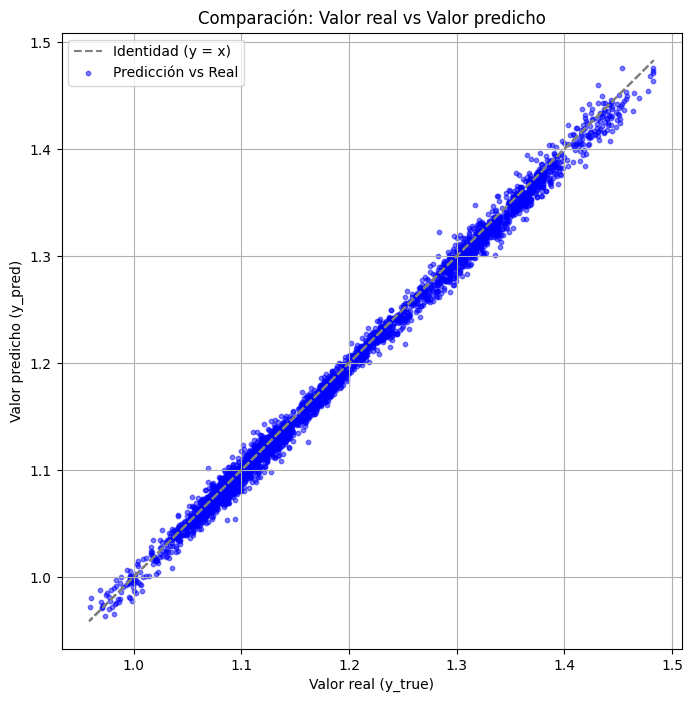

In [36]:
import numpy as np

import matplotlib.pyplot as plt

# Gráfica de la identidad
plt.figure(figsize=(8, 8))
plt.plot(y_true_flat, y_true_flat, label="Identidad (y = x)", color='gray', linestyle='--')

# Gráfica de y_true vs y_pred
plt.scatter(y_true_flat, y_pred_flat_gru, alpha=0.5, label="Predicción vs Real", color='blue', s=10)

plt.xlabel("Valor real (y_true)")
plt.ylabel("Valor predicho (y_pred)")
plt.title("Comparación: Valor real vs Valor predicho")
plt.legend()
plt.grid(True)
plt.show()

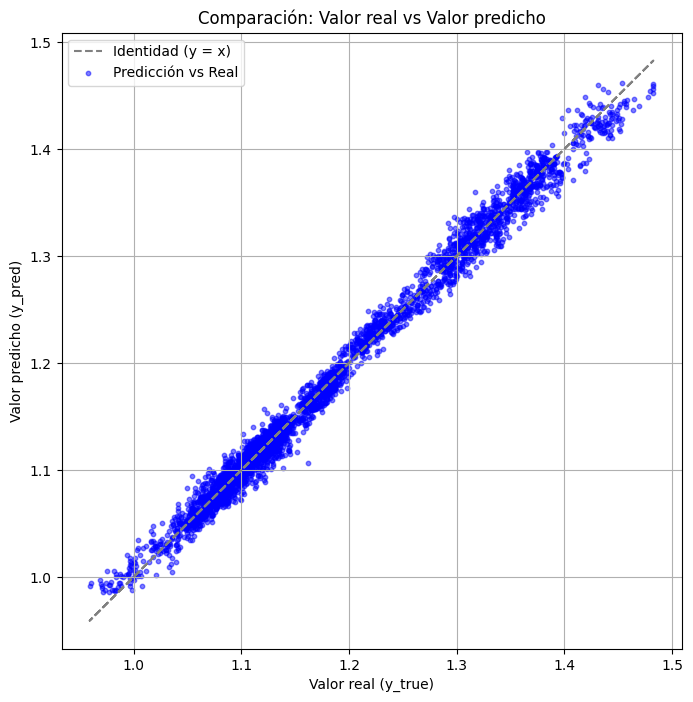

In [37]:
import numpy as np

import matplotlib.pyplot as plt

# Gráfica de la identidad
plt.figure(figsize=(8, 8))
plt.plot(y_true_flat, y_true_flat, label="Identidad (y = x)", color='gray', linestyle='--')

# Gráfica de y_true vs y_pred
plt.scatter(y_true_flat, y_pred_flat_contextual, alpha=0.5, label="Predicción vs Real", color='blue', s=10)

plt.xlabel("Valor real (y_true)")
plt.ylabel("Valor predicho (y_pred)")
plt.title("Comparación: Valor real vs Valor predicho")
plt.legend()
plt.grid(True)
plt.show()

In [43]:
# Instantiate model
model_ContextualLSTMTransformerFlexible2 = ContextualLSTMTransformerFlexible(
    seq_len=T,
    feature_dim=D,
    output_size=1,
    window_size=10,
    max_neighbors=2,
    lstm_units=64,
    num_heads=8,
    embed_dim=128,
    dropout_rate=0.1
).to(device)


best_model_ContextualLSTMTransformerFlexible, loss_train_ContextualLSTMTransformerFlexible, loss_val_ContextualLSTMTransformerFlexible = train_models(model_ContextualLSTMTransformerFlexible2,train_loader,val_loader)

model_ContextualLSTMTransformerFlexible2.load_state_dict(best_model_ContextualLSTMTransformerFlexible)


Epoch 1/100 - Train Loss: 0.079095 - Val Loss: 0.001680
Epoch 2/100 - Train Loss: 0.001085 - Val Loss: 0.000538
Epoch 3/100 - Train Loss: 0.000597 - Val Loss: 0.000359
Epoch 4/100 - Train Loss: 0.000539 - Val Loss: 0.000521
Epoch 5/100 - Train Loss: 0.000429 - Val Loss: 0.000571
Epoch 6/100 - Train Loss: 0.000424 - Val Loss: 0.000319
Epoch 7/100 - Train Loss: 0.000400 - Val Loss: 0.000406
Epoch 8/100 - Train Loss: 0.000361 - Val Loss: 0.000220
Epoch 9/100 - Train Loss: 0.000359 - Val Loss: 0.000652
Epoch 10/100 - Train Loss: 0.000347 - Val Loss: 0.000423
Epoch 11/100 - Train Loss: 0.000322 - Val Loss: 0.000663
Epoch 12/100 - Train Loss: 0.000355 - Val Loss: 0.000740
Epoch 13/100 - Train Loss: 0.000329 - Val Loss: 0.000543
Epoch 14/100 - Train Loss: 0.000513 - Val Loss: 0.000678
Epoch 15/100 - Train Loss: 0.000297 - Val Loss: 0.000326
Epoch 16/100 - Train Loss: 0.000296 - Val Loss: 0.000214
Epoch 17/100 - Train Loss: 0.000293 - Val Loss: 0.000155
Epoch 18/100 - Train Loss: 0.000285 - Va

<All keys matched successfully>

In [40]:
gc.collect()                          # Recolección de basura de Python
torch.cuda.empty_cache()             # Libera la memoria que no se está usando pero sigue asignada
torch.cuda.ipc_collect()  

In [44]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import torch
import matplotlib.pyplot as plt
model_ContextualLSTMTransformerFlexible2.eval()
# Predict for all X samples
X_2 = torch.tensor(X_scaled, dtype=torch.float32).to(device)
gc.collect()                          # Recolección de basura de Python
torch.cuda.empty_cache()             # Libera la memoria que no se está usando pero sigue asignada
torch.cuda.ipc_collect()             # Libera la memoria compartida entre procesos
y_pred_all_contextual2 = model_ContextualLSTMTransformerFlexible2(X_2).cpu().detach().numpy() 
gc.collect()                          # Recolección de basura de Python
torch.cuda.empty_cache()             # Libera la memoria que no se está usando pero sigue asignada
torch.cuda.ipc_collect()             # Libera la memoria compartida entre procesos
y_true_flat = y.reshape(-1)
y_pred_flat_contextual2 = y_pred_all_contextual2.flatten()


# Calculate metrics
mae_contextual2 = mean_absolute_error(y_true_flat, y_pred_flat_contextual2)
mse_contextual2 = mean_squared_error(y_true_flat, y_pred_flat_contextual2)
rmse_contextual2= np.sqrt(mse_contextual2)
r2_contextual2 = r2_score(y_true_flat, y_pred_flat_contextual2)
mape_contextual2 = np.mean(np.abs((y_true_flat - y_pred_flat_contextual2) / y_true_flat)) * 100

print(f"MAE: {mae_contextual2}")
print(f"MSE: {mse_contextual2}")
print(f"RMSE: {rmse_contextual2}")
print(f"R^2: {r2_contextual2}")
print(f"MAPE: {mape_contextual2}")

MAE: 0.007362559014204874
MSE: 9.298737462402941e-05
RMSE: 0.009642996143524554
R^2: 0.992662406413411
MAPE: 0.6196727497395632


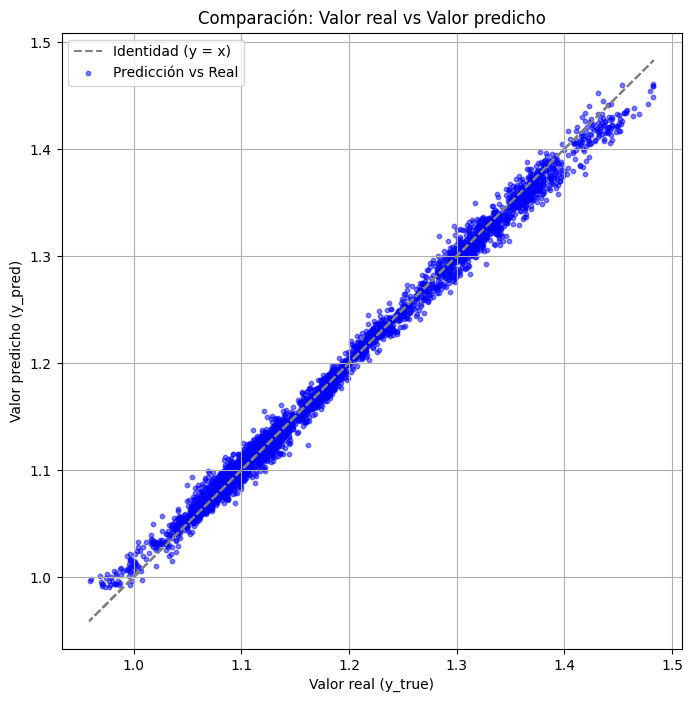

In [45]:
import numpy as np

import matplotlib.pyplot as plt

# Gráfica de la identidad
plt.figure(figsize=(8, 8))
plt.plot(y_true_flat, y_true_flat, label="Identidad (y = x)", color='gray', linestyle='--')

# Gráfica de y_true vs y_pred
plt.scatter(y_true_flat, y_pred_flat_contextual2, alpha=0.5, label="Predicción vs Real", color='blue', s=10)

plt.xlabel("Valor real (y_true)")
plt.ylabel("Valor predicho (y_pred)")
plt.title("Comparación: Valor real vs Valor predicho")
plt.legend()
plt.grid(True)
plt.show()

In [60]:
nueva_fila = pd.DataFrame([[
    'ContextualLSTMTransformerFlexible2',
    mae_contextual2,
    mse_contextual2,
    rmse_contextual2,
    r2_contextual2,
    mape_contextual2
]], columns=results.columns)

results = pd.concat([results, nueva_fila], ignore_index=True)

In [61]:
results

,Model,MAE,MSE,RMSE,R^2,MAPE (%)
0,TLS_LSTMModel,0.006510,0.000073,0.008543,0.994241,0.547221
1,HybridLSTMAttentionModel,0.016368,0.000463,0.021514,0.963476,1.380579
2,BidirectionalDeepLSTMModel,NaN,NaN,NaN,NaN,NaN
3,GRU_Model,0.006679,0.000074,0.008599,0.994165,0.559682
4,ContextualLSTMTransformerFlexible,0.008659,0.000123,0.011112,0.990257,0.728151
5,ContextualLSTMTransformerFlexible2,0.007363,0.000093,0.009643,0.992662,0.619673


In [ ]:
#torch.save(model_ContextualLSTMTransformerFlexible2.state_dict(), 'model_ContextualLSTMTransformerFlexible2.pth')